<a href="https://colab.research.google.com/github/gasperjw/TelecomChurn/blob/main/TelecomChurnRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all relevant libraries and packages
import pandas as pd
%pylab inline
from patsy import dmatrices
from pandas import Series,DataFrame
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest as ztest
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as cat
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

from google.colab import files
uploaded = files.upload()

Populating the interactive namespace from numpy and matplotlib


Saving telecom_churn.csv to telecom_churn.csv


In [ ]:
#reading the csv data file and displaying the columns
df = pd.read_csv('telecom_churn.csv')
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


EDA Section:

In [ ]:
df.isnull().sum()               #No missing values in dataframe

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64

In [ ]:
#Showing the overall summary statistics for each column - finding out which columns might have outliers
df.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


In [ ]:
#Removed all rows with outlier values for predictor variables
df_without_outliers = df[(np.abs(stats.zscore(df['AccountWeeks'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['DataUsage'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['CustServCalls'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['DayMins'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['DayCalls'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['MonthlyCharge'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['OverageFee'])) < 3)]
df_without_outliers = df[(np.abs(stats.zscore(df['RoamMins'])) < 3)]
df_without_outliers

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.70,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.00,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.00,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.00,3,166.7,113,41.0,7.42,10.1
...,...,...,...,...,...,...,...,...,...,...,...
3328,0,192,1,1,2.67,2,156.2,77,71.7,10.78,9.9
3329,0,68,1,0,0.34,3,231.1,57,56.4,7.67,9.6
3330,0,28,1,0,0.00,2,180.8,109,56.0,14.44,14.1
3331,0,184,0,0,0.00,2,213.8,105,50.0,7.98,5.0


Text(0.5, 1.0, 'Correlation Heatmap')

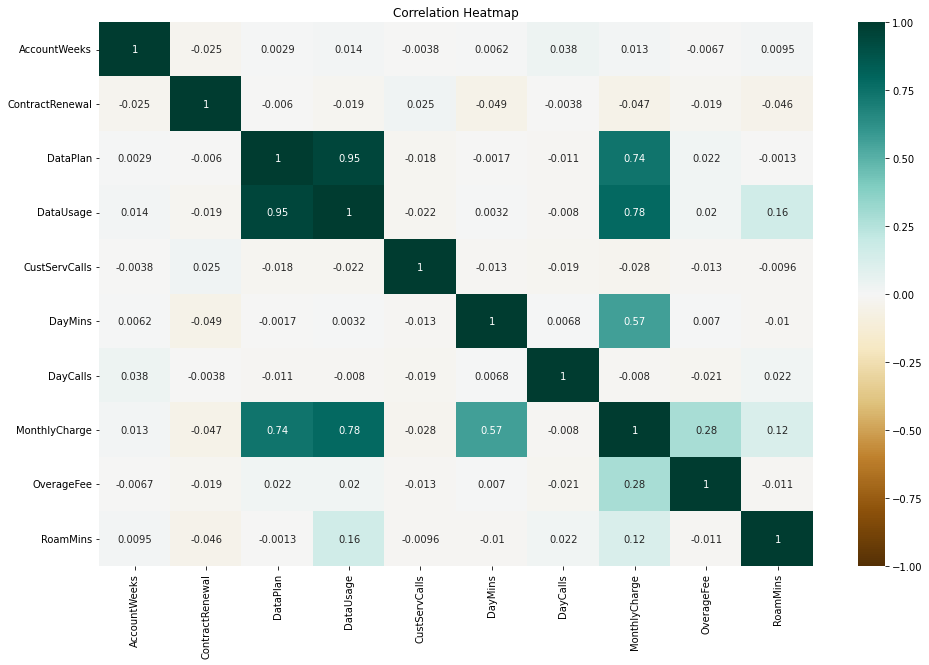

In [ ]:
df_predictors = df.loc[:,df.columns!='Churn']

#Building a correlation matrix for all the predictor variables
# update the color map for better interpretability
plt.figure(figsize=(16,10))
heatmap = cat.heatmap(df_predictors.corr(),vmin=-1,vmax=1,annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap')

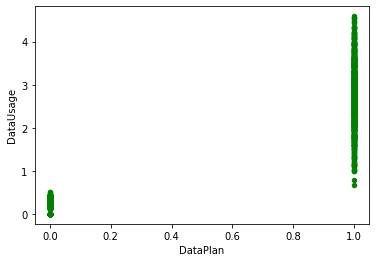

In [ ]:
scatter1 = df.plot.scatter(x='DataPlan',y='DataUsage',color='green')

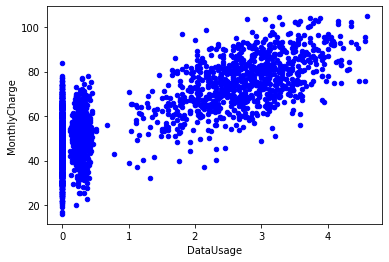

In [ ]:
scatter2 = df.plot.scatter(x='DataUsage',y='MonthlyCharge',color='blue')

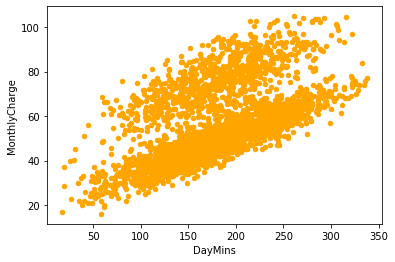

In [ ]:
scatter3 = df.plot.scatter(x='DayMins',y='MonthlyCharge',color='orange')

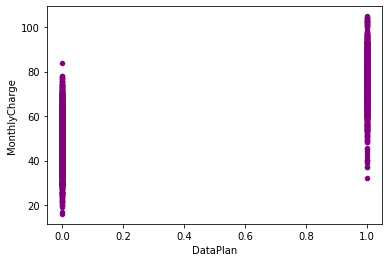

In [ ]:
scatter4 = df.plot.scatter(x='DataPlan',y='MonthlyCharge',color='purple')

In [ ]:
#Creating masks to segregate different target variable value rows
mask = df['Churn']==1
mask2 = df['Churn']==0

In [ ]:
ztest(df[mask]['AccountWeeks'],df[mask2]['AccountWeeks'],value=0)

(1.0755245708633754, 0.28213993758232336)

In [ ]:
ztest(df[mask]['ContractRenewal'],df[mask2]['ContractRenewal'],value=0)

(-15.403368347317059, 1.5536126166531474e-53)

In [ ]:
ztest(df[mask]['DataPlan'],df[mask2]['DataPlan'],value=0)

(-5.913797477414694, 3.343089032326777e-09)

In [ ]:
ztest(df[mask]['DataUsage'],df[mask2]['DataUsage'],value=0)

(-5.146495245820853, 2.6539818723406005e-07)

In [ ]:
ztest(df[mask]['CustServCalls'],df[mask2]['CustServCalls'],value=0)

(9.813784144760392, 9.821479547969149e-23)

In [ ]:
ztest(df[mask]['DayMins'],df[mask2]['DayMins'],value=0)

(13.050355934514887, 6.325120367620992e-39)

In [ ]:
ztest(df[mask]['DayCalls'],df[mask2]['DayCalls'],value=0)

(1.3303545111075537, 0.1834014947173277)

In [ ]:
ztest(df[mask]['MonthlyCharge'],df[mask2]['MonthlyCharge'],value=0)

(4.688621886800647, 2.750510699510948e-06)

In [ ]:
ztest(df[mask]['OverageFee'],df[mask2]['OverageFee'],value=0)

(5.638802149523751, 1.7123714468141607e-08)

In [ ]:
ztest(df[mask]['RoamMins'],df[mask2]['RoamMins'],value=0)

(3.751771582379649, 0.0001755894071175946)

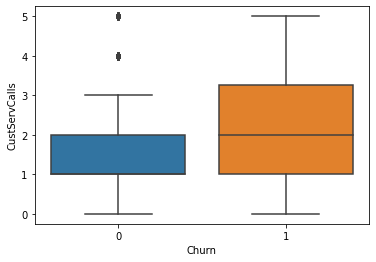

In [ ]:
cat.boxplot(x=df['Churn'],y=df['CustServCalls'],data=df)
#plt.show()

In [ ]:
custcall_levels = pd.cut(df['CustServCalls'],bins=2,labels=['low','high'])
custcall_levels
custcalls_versus_target = pd.crosstab(custcall_levels,df['Churn'])
custcalls_versus_target

Churn,0,1
CustServCalls,,
low,2290,295
high,491,157


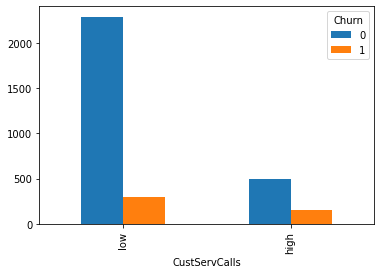

In [ ]:
custcalls_versus_target.plot(kind='bar')

1. EDA on the telecom dataset

# Decision Trees

In [ ]:
df_telecom = pd.read_csv('telecom_churn.csv')
df_telecom.columns.values

array(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan',
       'DataUsage', 'CustServCalls', 'DayMins', 'DayCalls',
       'MonthlyCharge', 'OverageFee', 'RoamMins'], dtype=object)

In [ ]:
#attempted front-wise subset selection
formula = 'Churn ~ AccountWeeks + ContractRenewal + DataUsage + CustServCalls + DayMins + DayCalls + MonthlyCharge + OverageFee + RoamMins'
Y,X = dmatrices(formula,df_telecom,return_type='dataframe')

y = Y['Churn'].values

# Split intro training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
# Create the folds in the training data
from sklearn.metrics import accuracy_score



kfold = StratifiedKFold(n_splits=3, shuffle=True)

# Iterate over max_depth
for max_depth in [1, 2, 3, 4, 5]:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('max_depth={} scores={} avg_score={}'.format(max_depth, scores, scores.mean(), accuracy_score))

max_depth=1 scores=[0.85089974 0.85475578 0.85585586] avg_score=0.8538371276160479
max_depth=2 scores=[0.87660668 0.8714653  0.88416988] avg_score=0.8774139545347772
max_depth=3 scores=[0.8933162  0.90616967 0.9034749 ] avg_score=0.9009869215524743
max_depth=4 scores=[0.91131105 0.91645244 0.92664093] avg_score=0.9181348075949618
max_depth=5 scores=[0.91902314 0.91645244 0.93050193] avg_score=0.9219925029693669


In [ ]:
#Fitting the model
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
result = model.fit(X_train, y_train)

#Accuracy on training set
prediction_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, prediction_train))

0.944706386626661


In [ ]:
prediction = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediction))

0.923


# Ensemble Methods

In [ ]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

## Tuning Random Forest to find n-estimators and Max_depth

In [ ]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train,y_train)

NameError: ignored

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

display(cv)

Best parameters are: {'max_depth': None, 'n_estimators': 50}


0.868 + or -0.012 for the {'max_depth': 2, 'n_estimators': 5}
0.861 + or -0.006 for the {'max_depth': 2, 'n_estimators': 10}
0.856 + or -0.001 for the {'max_depth': 2, 'n_estimators': 50}
0.856 + or -0.002 for the {'max_depth': 2, 'n_estimators': 100}
0.856 + or -0.001 for the {'max_depth': 2, 'n_estimators': 250}
0.904 + or -0.009 for the {'max_depth': 4, 'n_estimators': 5}
0.908 + or -0.012 for the {'max_depth': 4, 'n_estimators': 10}
0.909 + or -0.011 for the {'max_depth': 4, 'n_estimators': 50}
0.91 + or -0.006 for the {'max_depth': 4, 'n_estimators': 100}
0.91 + or -0.007 for the {'max_depth': 4, 'n_estimators': 250}
0.919 + or -0.012 for the {'max_depth': 8, 'n_estimators': 5}
0.932 + or -0.009 for the {'max_depth': 8, 'n_estimators': 10}
0.934 + or -0.008 for the {'max_depth': 8, 'n_estimators': 50}
0.938 + or -0.009 for the {'max_depth': 8, 'n_estimators': 100}
0.936 + or -0.007 for the {'max_depth': 8, 'n_estimator

In [ ]:
models = {}
models['Random Forest'] = \
    RandomForestClassifier(n_estimators=250, max_depth = 8, 
                           random_state=1, class_weight='balanced')

In [ ]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Random Forest


In [ ]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)

    #updated code
    yhat = model.predict_proba(X_test)
    yhat_positive = yhat[:, 1]

    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

NameError: ignored

In [ ]:
from sklearn.metrics import precision_score
# calculate precision for binary classification problem
precision = precision_score(y_test, prediction_test, average='binary')
print("The precision for this model is:", precision.round(3))

#Precision is the ratio of true positives to the total positives predicted by a classifier.

The precision for this model is: 0.712


In [ ]:
from sklearn.metrics import recall_score
# calculate recall for binary classification problem
recall = recall_score(y_test, prediction_test, average='binary')
print("The recall for this model is:", recall.round(3))

# Recall is the ratio of true positives to the ground-truth positives in the sample.


The recall for this model is: 0.683


In [ ]:
from sklearn.metrics import f1_score
# calculate recall for binary classification problem
fscore = f1_score(y_test, prediction_test, average='binary')
print("The recall for this F-score is:", fscore.round(3))

# F-Score provides a single score to measure both Precision and Recall.

The recall for this F-score is: 0.697


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
def plot_roc (test_y1, yhat_positive1):

    fpr, tpr, thresholds = roc_curve(test_y1,  yhat_positive1)
    length = len(thresholds)

    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, label='Logistic')
    idx_list  =np.linspace(0,length, num=20).astype(int)

    for ix in idx_list:
        try:
            plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=thresholds[ix])
            plt.text(fpr[ix], tpr[ix], str(round(thresholds[ix],2)))
        except:
            continue

    #generating the roc curve plot
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    # getting the AUC score for the roc curve
    roc_score = roc_auc_score(test_y1, yhat_positive1)
    print("ROC_AUC: "+ str(round(roc_score,2)))

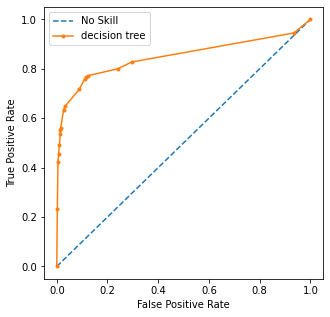

AUROC: 0.824


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# plot no skill roc curve - the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate inputs for the roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat_positive)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

# calculate and print AUROC
roc_auc = roc_auc_score(y_test, prediction_test)
print('AUROC: %.3f' % roc_auc)

Attempting Using Different Thresholds 

In [ ]:
# .4 
models = {}
models['Random Forest'] = \
    RandomForestClassifier(n_estimators=250, max_depth = 8, 
                           random_state=1, class_weight='balanced')
    
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)
              

Fitting Random Forest


array([[0.89460032, 0.10539968],
       [0.8303696 , 0.1696304 ],
       [0.89554293, 0.10445707],
       ...,
       [0.80356159, 0.19643841],
       [0.87468366, 0.12531634],
       [0.88716951, 0.11283049]])

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


threshold = 0.4

predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
print("The Threshold for this model is", threshold)
print("The accuracy for this model is", accuracy)

#prec
precision = precision_score(y_test, predicted, average='binary')
print("The precision for this model is:", precision.round(3))

#recal
recall = recall_score(y_test, predicted, average='binary')
print("The recall for this model is:", recall.round(3))

#f-score
fscore = f1_score(y_test, predicted, average='binary')
print("The recall for this F-score is:", fscore.round(3))



The Threshold for this model is 0.4
The accuracy for this model is 0.904
The precision for this model is: 0.648
The recall for this model is: 0.738
The recall for this F-score is: 0.69


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


threshold = 0.3

predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
print("The Threshold for this model is", threshold)
print("The accuracy for this model is", accuracy)

#prec
precision = precision_score(y_test, predicted, average='binary')
print("The precision for this model is:", precision.round(3))

#recal
recall = recall_score(y_test, predicted, average='binary')
print("The recall for this model is:", recall.round(3))

#f-score
fscore = f1_score(y_test, predicted, average='binary')
print("The recall for this F-score is:", fscore.round(3))



The Threshold for this model is 0.3
The accuracy for this model is 0.885
The precision for this model is: 0.576
The recall for this model is: 0.786
The recall for this F-score is: 0.665


In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score


threshold = 0.25

predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
print("The Threshold for this model is", threshold)
print("The accuracy for this model is", accuracy)

#prec
precision = precision_score(y_test, predicted, average='binary')
print("The precision for this model is:", precision.round(3))

#recal
recall = recall_score(y_test, predicted, average='binary')
print("The recall for this model is:", recall.round(3))

#f-score
fscore = f1_score(y_test, predicted, average='binary')
print("The recall for this F-score is:", fscore.round(3))



The Threshold for this model is 0.25
The accuracy for this model is 0.87
The precision for this model is: 0.535
The recall for this model is: 0.793
The recall for this F-score is: 0.639


# Final Random Forest Model

In [ ]:
models = {}
# models['Random Forest'] = \
#     RandomForestClassifier(n_estimators=250, max_depth = 8, 
#                            random_state=1, class_weight='balanced')
    
models['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1, class_weight='balanced')
    
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.35

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)

    #updated code
    yhat = model.predict_proba(X_test)
    yhat_positive = yhat[:, 1]
    predicted_proba = model.predict_proba(X_test)

    predicted = (predicted_proba [:,1] >= threshold).astype('int')


    accuracy_test[name] = metrics.accuracy_score(y_test, predicted)
    


predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)

#prec
precision = precision_score(y_test, predicted, average='binary')

#recal
recall = recall_score(y_test, predicted, average='binary')

#f-score
fscore = f1_score(y_test, predicted, average='binary')

df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test, 'Precision': precision, 'Recall':recall, 'fscore': fscore})

df

,Training Accuracy,Test Accuracy,Precision,Recall,fscore
Decision Tree,0.895414,0.86,0.511416,0.772414,0.615385


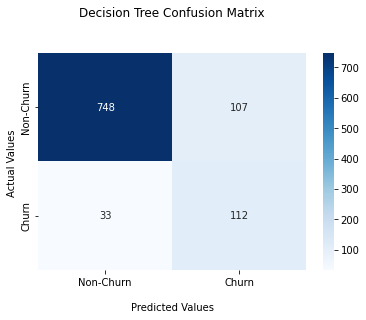

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score

import seaborn as sns

cf_matrix = confusion_matrix(y_test, predicted)


ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Decision Tree Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Non-Churn','Churn'])
ax.yaxis.set_ticklabels(['Non-Churn','Churn'])

## Display the visualization of the Confusion Matrix.
plt.show()

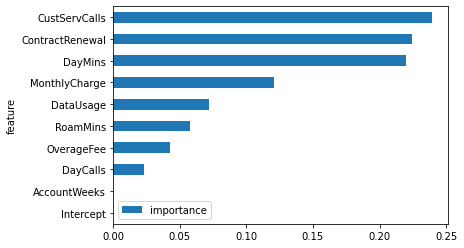

In [ ]:
feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
feature_importance["importance"] = model.feature_importances_
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
ax = feature_importance.plot.barh(x='feature', y='importance')

plt.rcParams["figure.figsize"]=(5,5)

# **KNN**

In [ ]:
df_telecom['Churn'].value_counts()
from sklearn import neighbors
model = neighbors.KNeighborsClassifier(n_neighbors=15,
                                       weights='uniform',
                                       p=2)


0.8928418345477925
0.888
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       855
         1.0       0.75      0.34      0.47       145

    accuracy                           0.89      1000
   macro avg       0.83      0.66      0.70      1000
weighted avg       0.88      0.89      0.87      1000



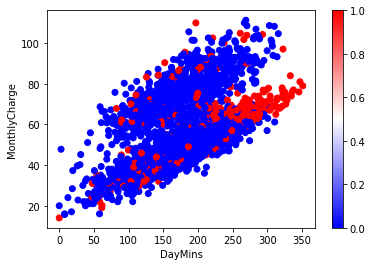

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
df_telecom['target'] = 0.0
mask = df_telecom['Churn'] == 1
df_telecom.loc[mask, 'target'] = 1.0
Y, X = dmatrices('target ~ 0 + DayMins + MonthlyCharge', df_telecom, return_type='dataframe')
y = Y['target'].values

sc = scatter(X['DayMins'], X['MonthlyCharge'], c=y, cmap='bwr')
colorbar(sc)
xlabel('DayMins')
ylabel('MonthlyCharge')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train, y_train)
predicted_classes_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, predicted_classes_train))
predicted_classes = model.predict(X_test)
print(metrics.accuracy_score(y_test, predicted_classes))

yhat = model.predict_proba(X_test)
yhat_positive = yhat[:, 1]
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

Training Set Accuracy: 0.893

  Test Set Accuracy: 0.888
  
Lets see if using the top 6 variables helps:

In [ ]:
df_telecom['target'] = 0.0
mask = df_telecom['Churn'] == 1
df_telecom.loc[mask, 'target'] = 1.0
Y, X = dmatrices('target ~ 0 + DayMins + MonthlyCharge + CustServCalls + OverageFee + RoamMins + ContractRenewal', df_telecom, return_type='dataframe')
y = Y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train, y_train)
predicted_classes_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, predicted_classes_train))
predicted_classes = model.predict(X_test)
print(metrics.accuracy_score(y_test, predicted_classes))

yhat = model.predict_proba(X_test)
yhat_positive = yhat[:, 1]
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

0.896699528504072
0.892
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       855
         1.0       0.79      0.34      0.48       145

    accuracy                           0.89      1000
   macro avg       0.85      0.66      0.71      1000
weighted avg       0.88      0.89      0.87      1000



Training Set Accuracy: 0.8967

  Test Set Accuracy: 0.892 (slight improvement in test set accuracy)
  
Lets see if using all of the variables helps any more:

In [ ]:
from sklearn.model_selection import train_test_split
df_telecom['target'] = 0.0
mask = df_telecom['Churn'] == 1
df_telecom.loc[mask, 'target'] = 1.0
Y, X = dmatrices('target ~ 0 + DataUsage + OverageFee + AccountWeeks + ContractRenewal + DataPlan + CustServCalls + DayMins + DayCalls + MonthlyCharge + RoamMins', df_telecom, return_type='dataframe')
y = Y['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model.fit(X_train, y_train)

predicted_classes_train = model.predict(X_train)
print(metrics.accuracy_score(y_train, predicted_classes_train))

predicted_classes = model.predict(X_test)
print(metrics.accuracy_score(y_test, predicted_classes))

yhat = model.predict_proba(X_test)
yhat_positive = yhat[:, 1]
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


0.8812687526789541
0.877
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       855
         1.0       0.72      0.25      0.37       145

    accuracy                           0.88      1000
   macro avg       0.80      0.62      0.65      1000
weighted avg       0.86      0.88      0.85      1000



Training Set Accuracy: 0.881

Test Set Accuracy: 0.877

Doing a bit worse than just using the top 6 variables

Lets use cross-validation to choose the correct K:

In [ ]:
from sklearn import model_selection

kfold = model_selection.StratifiedKFold(n_splits=3).split(X=X[:6], y=[0,0,0,1,1,1])

for train, holdout in kfold:
    print('train indices =', train, 'holdout indices =', holdout)



train indices = [1 2 4 5] holdout indices = [0 3]
train indices = [0 2 3 5] holdout indices = [1 4]
train indices = [0 1 3 4] holdout indices = [2 5]


[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


Text(0, 0.5, 'Accuracy of classifier')

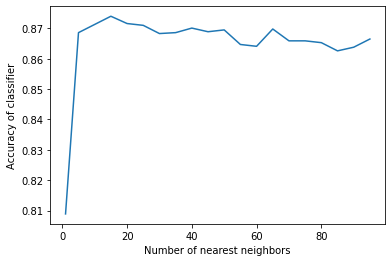

In [ ]:
def cv_accuracy_score(X, y, nn):
    """For each fold, fit the nearest neighbors model
    with nn nearest neighbors on the train, and return accuracy
    on the test."""
    
    model = neighbors.KNeighborsClassifier(n_neighbors=nn,
                                           weights='uniform')
    accuracies = []
    
    kfold = model_selection.StratifiedKFold(n_splits=3, shuffle=True).split(X, y)
    for train, holdout in kfold:
        # Select the training and testing data using the indices
        # provided by kfold
        X_train = X.iloc[train]
        X_holdout = X.iloc[holdout]
        y_train = y[train]
        y_holdout = y[holdout]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Compute test accuracy
        accuracy = metrics.accuracy_score(y_holdout, model.predict(X_holdout))
        accuracies.append(accuracy)
    
    average_accuracy = Series(accuracies).mean()
    return average_accuracy

cv_accuracy_score(X, y, nn=1)

nn = [1] + [(x + 1) * 5 for x in range(19)]
print(nn)
scores = [cv_accuracy_score(X, y, num_nbrs) for num_nbrs in nn]
plot(nn, scores)
xlabel('Number of nearest neighbors')
ylabel('Accuracy of classifier')


Seems like any K value above 10 will do 

AdaBoost Classification Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, r2_score, accuracy_score, roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib as plt

In [ ]:
#reading the data file
df_raw = pd.read_csv('telecom_churn.csv')

# getting the X and y variable
X = df_raw.loc[:,~df_raw.columns.isin(['Churn'])].copy()
y = df_raw['Churn'].copy()

#creating a test-train split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=20)

In [ ]:
#running ada boost model without any cross-validation and hyperparameter tunining

classifier = AdaBoostClassifier(RandomForestClassifier(max_depth=5), n_estimators=100, random_state=10)
classifier.fit(train_X,train_y)

yhat = classifier.predict_proba(test_X)
yhat_positive = yhat[:, 1]
y_pred = classifier.predict(test_X)

print(classification_report(test_y, y_pred))

# getting the AUC score for the roc curve
roc_score = roc_auc_score(test_y, yhat_positive)
print("ROC_AUC: "+ str(round(roc_score,2)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       576
           1       0.86      0.66      0.75        91

    accuracy                           0.94       667
   macro avg       0.90      0.82      0.86       667
weighted avg       0.94      0.94      0.94       667

ROC_AUC: 0.92


As we can see, with starting parameters, we are getting a good accuracy but low recall. We can fine-tune our model to improve the same using cross-valdidation
Baseline AUC: 0.92

In [ ]:
#using grid search to fine tune the hyperparameters

#setting the parameters range
grid = dict()
grid['n_estimators'] = [50,70,90,120,150,180,200,300,400,500]
grid['base_estimator__max_depth'] = [3, 5, 10,15,20,30]

#setting up the models
model = AdaBoostClassifier(base_estimator = RandomForestClassifier())
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=10)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# execute the grid search
grid_result = grid_search.fit(train_X, train_y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))